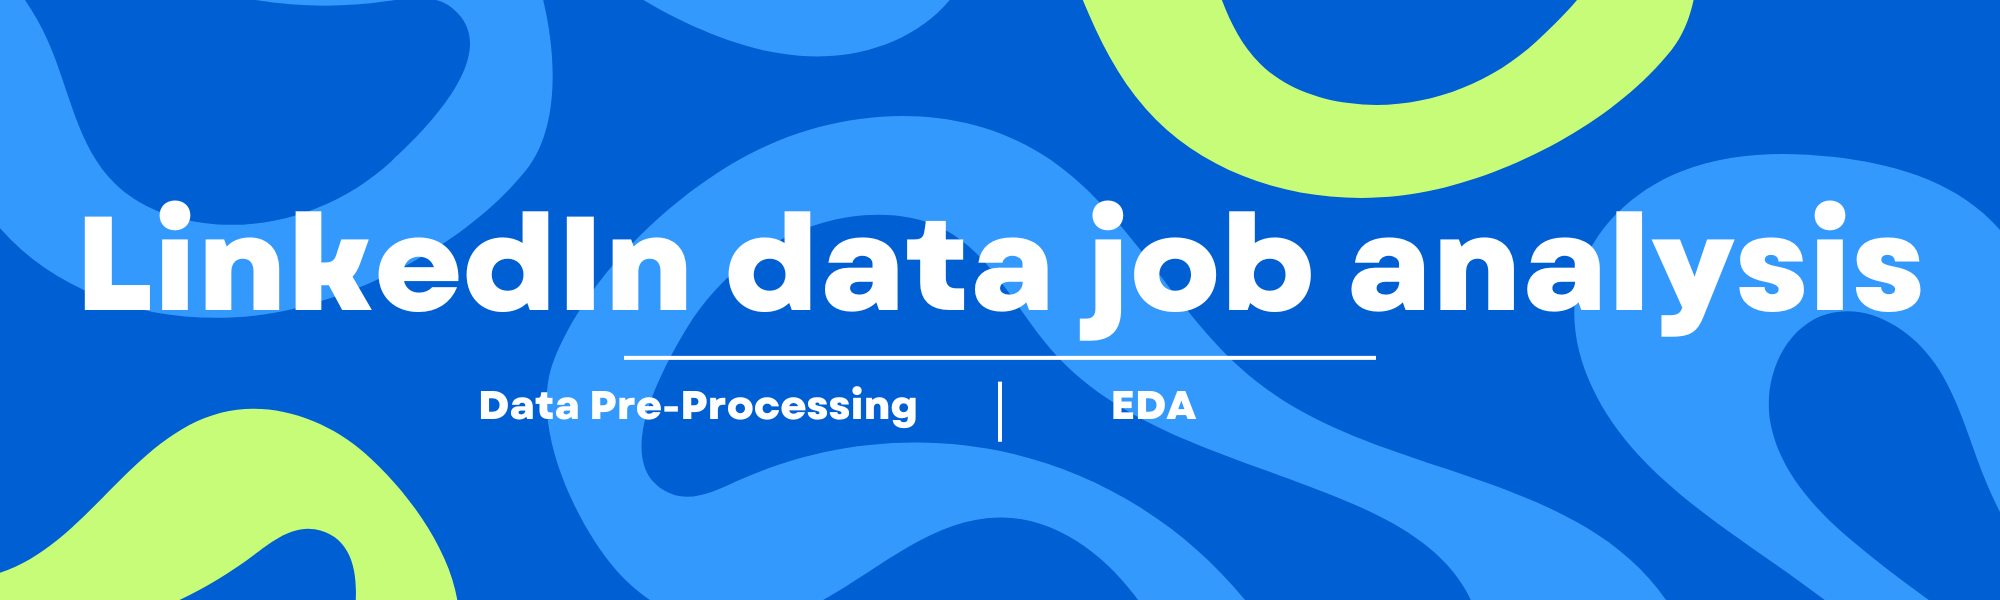

<div class="alert alert-info">
    <b> Table of Contents </b>

1. [Loading the data](#Loading_the_data)
3. [Preprocessing](#Preprocessing)
4. [Heatmap](#Heatmap)
5. [Wordcloud of titles and descriptions](#Wordcloud_of_titles_and_descriptions)
6. [Pieplot of the biggest companies](#Pieplot_of_the_biggest_companies)
7. [Treemap of regions and locations](#Treemap_of_regions_and_locations)
8. [Line graph showcasing timeline of job postings](#Line_graph_showcasing_timeline_of_job_postings)
9. [Barplots with Seniority levels and Employment Types](#Barplots_with_Seniority_levels_and_Employment_Types)
10. [Horizontal Barplots with Job functions and Industries](#Horizontal_Barplots_with_Job_functions_and_Industries)
11. [Barplot with Skills](#Barplot_with_Skills)

> <div class="alert alert-info">
    <b><i>Loading the data</i></b>
    <a id="Loading the data"></a>

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv('raw_linkedin_data_dk.csv')
data = raw_data.drop_duplicates().drop(columns='Unnamed: 0')
data.sort_values(by=['Date'], inplace=True)

> <div class="alert alert-info">
    <b><i>Preprocessing</i></b>
    <a id="Preprocessing"></a>

In [5]:
import re
import string

for column in data:
    if data[column].dtype == 'object' and column != 'Date': 
        data[column] = data[column].astype(str)
        data[column] = data[column].fillna('').str.strip() 
        data[column] = data[column].str.replace('\n', ' ', regex=True)  
        data[column] = data[column].str.replace(r'(?<!\s)\n(?!\s)', ' ', regex=True)  
        data[column] = data[column].str.lower()
        data[column] = data[column].str.translate(str.maketrans('', '', string.punctuation)) 

#### Adding a column to split the location into a general region and a more precise location

In [7]:
data['Region'] = data['Location']
data = data.iloc[:, [0, 1, 9, 2, 3, 4, 5, 6, 7, 8]]

stop_words_location = ['region', 'denmark', 'municipality', 'metropolitan']
stop_words_region = ['region', 'denmark', 'municipality', 'metropolitan']
stop_words_title = ['copenhagen', 'sr', 'llm', 'Sr', 'senior']

data['Location'] = data['Location'].str.replace(r'\b(?:' + '|'.join(stop_words_location) + r')\b', '', regex=True).str.strip()
data['Region'] = data['Region'].str.replace(r'\b(?:' + '|'.join(stop_words_region) + r')\b', '', regex=True).str.strip()
data['Title'] = data['Title'].str.replace(r'\b(?:' + '|'.join(stop_words_title) + r')\b', '', regex=True).str.strip()

#### Categorizing regions and locations 

In [9]:
cities = pd.read_csv('dk(1).csv')
cities = cities['city'].str.lower()

def categorize_region(loc):
    loc = str(loc).lower()
    if 'south' in loc:
        return 'South-Jutland'
    elif 'north' in loc:
        return 'North-Jutland'
    elif 'zealand' in loc:
        return 'Zealand'
    elif 'aarhus' in loc or 'central' in loc:
        return 'Central-Denmark-Region'
    elif 'copenhagen' in loc:
        return 'Capital'
    elif 'capital' in loc:
        return 'Capital'
    else:
        return 'Other/Unknown'
        
def categorize_location(loc):
    loc = str(loc).lower()
    for city in cities.values:
        if city in loc:
            return city
    if 'københavn' in loc:
        return 'copenhagen'
    elif 'gentofte' in loc:
        return 'gentofte'
    elif 'capital' in loc:
        return 'copenhagen'
    elif 'hellerup' in loc:
        return 'hellerup'
    elif 'billund' in loc:
        return 'billund'
    elif 'brande' in loc:
        return 'brande'
    elif 'nordborg' in loc:
        return 'nordborg'
    else:
        return 'Other/Unknown'

data['Region'] = data['Region'].apply(categorize_region).str.capitalize()
data['Location'] = data['Location'].apply(categorize_location).str.capitalize()

#### Removing stopwords in both danish and english descriptions

In [11]:
import spacy

dk = set(stopwords.words('danish'))
eng = set(stopwords.words('english'))
stop_words = eng.union(dk)

def remove_stopwords(text):
    if isinstance(text, str):  
        words = text.split() 
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words) 
    return text 
data['Description'] = data['Description'].apply(remove_stopwords)

C:\Users\Alan\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# Exploratory Data Analysis

##### Looking at the unique and most frequent values in the cleaned dataset

In [14]:
data.describe().T

,count,unique,top,freq
Title,1483,1147,data scientist,30
Company,1483,615,novo nordisk,38
Region,1483,6,Capital,1113
Location,1483,62,Copenhagen,968
Date,1483,138,2025-04-01,58
Description,1483,1341,nan,15
Seniority_Level,1483,8,midsenior level,496
Job_Function,1483,181,information technology,202
Industry,1483,262,it services and it consulting,145
Employment_Type,1483,8,fulltime,1186


> <div class="alert alert-info">
    <b><i>Heatmap</i></b>
    <a id="Heatmap"></a>
#### Looking at the correlation between columns, the only relevant being the correlation between overall regions and more precise locations

<Axes: >

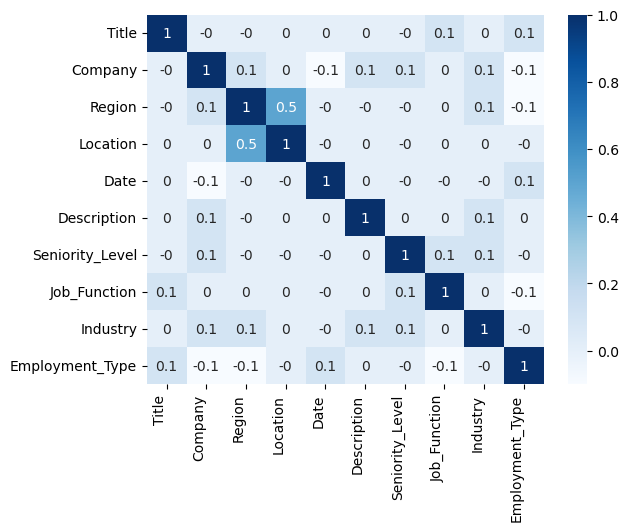

In [16]:
from sklearn import preprocessing
encoded_data = pd.DataFrame()
label_encoder = preprocessing.LabelEncoder()
encoded_data = data.copy()
for column in encoded_data:
    encoded_data[column] = label_encoder.fit_transform(encoded_data[column])
matrix = encoded_data.corr().round(1)
plt.xticks(range(len(matrix)), rotation=45, ha='right')
plt.yticks(range(len(matrix)))
sns.heatmap(matrix, cmap="Blues", annot=True)

> <div class="alert alert-info">
    <b><i>Wordcloud of titles and descriptions</i></b>
    <a id="Wordcloud_of_titles_and_descriptions"></a>
#### Looking into the most popular and frequent words in the job titles and descriptions

(-0.5, 699.5, 399.5, -0.5)

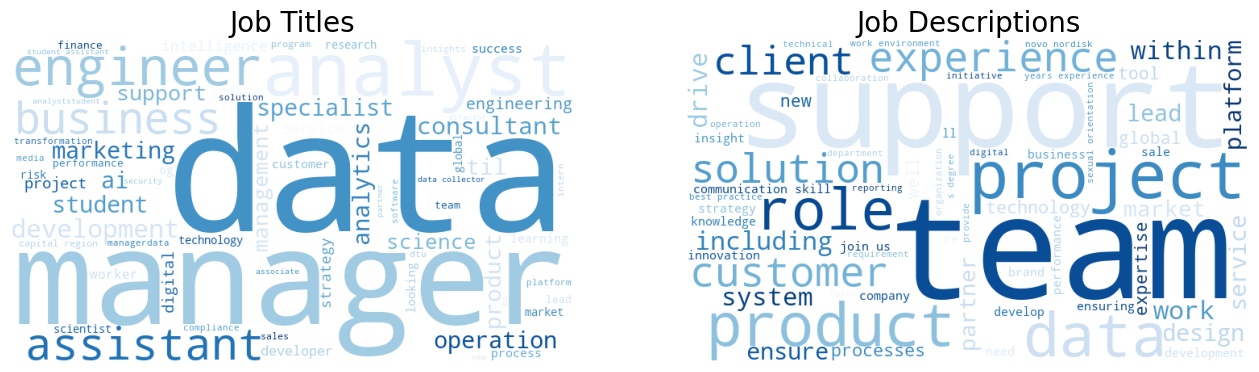

In [115]:
from collections import Counter

all_titles = []
all_descriptions = []
for title in data['Title']:
    title = title.lower()
    all_titles.append(title)
for description in data['Description']:
    all_descriptions.append(str(description))

nlp = spacy.load('en_core_web_sm')
for row in data['Description']:
    row = str(row)
    row = nlp(row)

all_words_titles, all_words_desc = ''.join(all_titles), ''.join(all_descriptions)
count_titles, count_desc = Counter(all_words_titles), Counter(all_words_desc)

wordcloud_titles = WordCloud(width = 700, height = 400,
                background_color ='white',
                colormap='Blues',
                min_font_size = 10).generate(all_words_titles)
 
wordcloud_desc = WordCloud(width=700, height=400, 
                background_color='white',
                colormap='Blues',
                min_font_size = 10).generate(all_words_desc)

data['Title'].value_counts().nlargest(5).values

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_titles)
axes[0].set_title("Job Titles", fontsize=20)
axes[0].axis("off")

axes[1].imshow(wordcloud_desc)
axes[1].set_title("Job Descriptions", fontsize=20)
axes[1].axis("off")

> <div class="alert alert-info">
    <b><i>Pieplot of the biggest companies</i></b>
    <a id="Pieplot_of_the_biggest_companies"></a>
#### Companies with most job listings

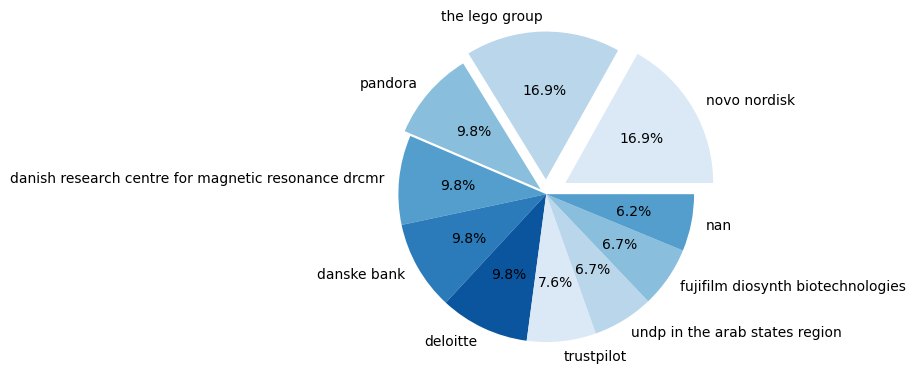

In [29]:
palette_color = sns.color_palette("Blues")
explode = [0.15, 0.1, 0.05, 0, 0, 0, 0, 0, 0, 0] 
plt.pie(data['Company'].value_counts()[:10], labels=data['Company'].value_counts()[:10].index, colors=palette_color, explode=explode, autopct='%1.1f%%')
plt.show()

> <div class="alert alert-info">
    <b><i>Treemap of regions and locations</i></b>
    <a id="Treemap_of_regions_and_locations"></a>
#### Exploring the most popular regions and cities where jobs are located in

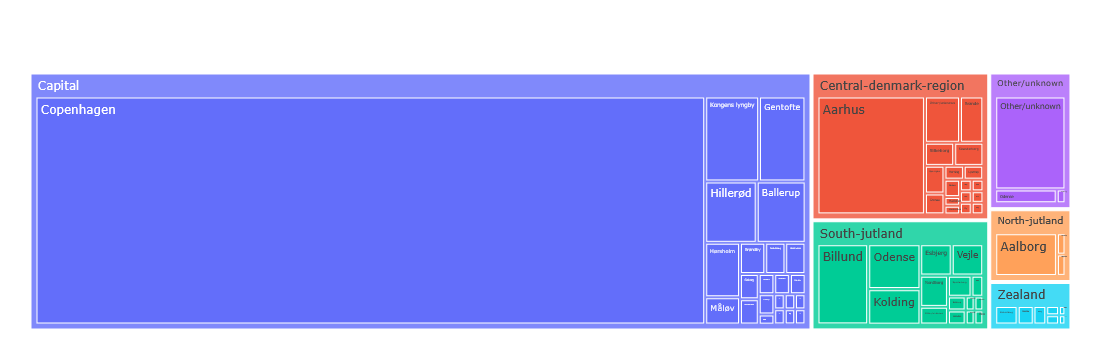

In [121]:
import plotly.express as px
import numpy as np

fig = px.treemap(data, names='Region', path=['Region', 'Location'])
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

> <div class="alert alert-info">
    <b><i>Line graph showcasing timeline of job postings</i></b>
    <a id="Line_graph_showcasing_timeline_of_job_postings"></a>
#### Showcasing the amount of data jobs across last 3 months

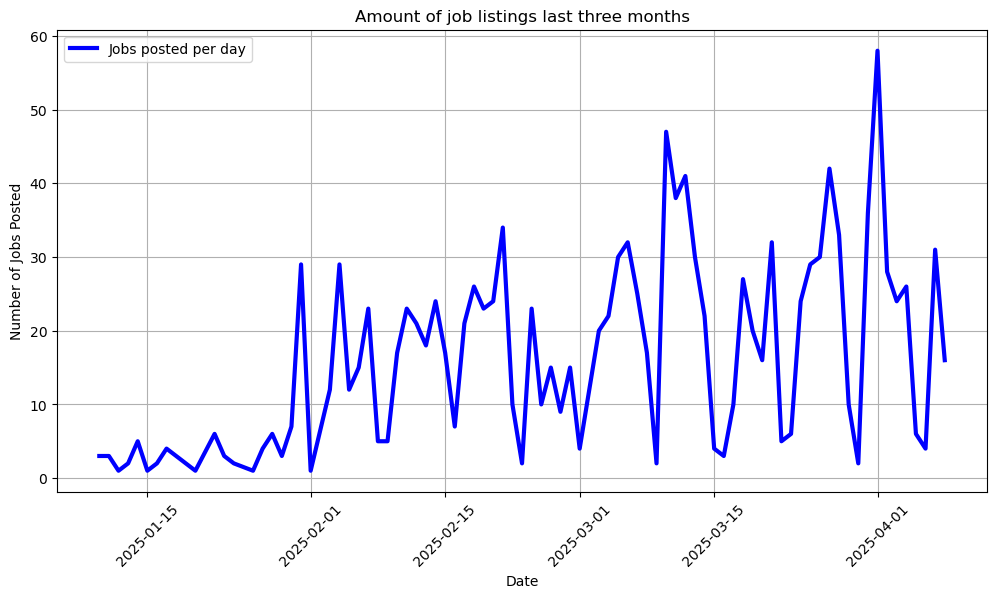

In [123]:
from datetime import datetime, timedelta
pd.options.mode.chained_assignment = None

data['Date'] = pd.to_datetime(data['Date'])

daily_counts = data.groupby(data['Date'].dt.date).size().reset_index(name='Job_Count')
daily_counts['Date'] = pd.to_datetime(daily_counts['Date'])

n = 1
for row in daily_counts['Job_Count']:
    daily_counts.loc[n, 'Job_Amount'] = daily_counts['Job_Count'][:n].sum()
    n += 1
    
current_date = datetime.now()
three_months_ago = current_date - timedelta(days=90)
three_months_time = daily_counts[daily_counts['Date'] >= three_months_ago]
three_months_time['Date'] = pd.to_datetime(three_months_time['Date'])

plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Job_Count', data=three_months_time, linewidth=3, label='Jobs posted per day', color='blue')

plt.xlabel('Date')
plt.ylabel('Number of Jobs Posted')
plt.title('Amount of job listings last three months')
plt.xticks(rotation=45) 
plt.grid(True)

> <div class="alert alert-info">
    <b><i>Barplots with Seniority levels and Employment Types</i></b>
    <a id="Barplots_with_Seniority_levels_and_Employment_Types"></a>
#### Showing seniority levels and employment types that are most sought after

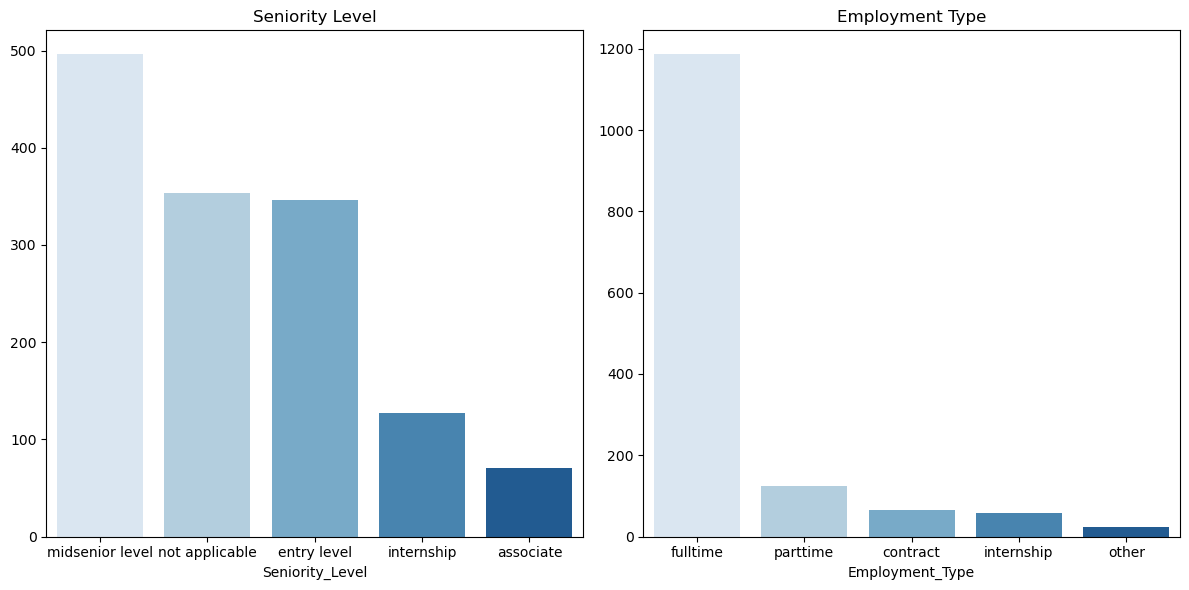

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create bar plots
sns.barplot(x=data['Seniority_Level'].value_counts().nlargest(5).index, 
            y=data['Seniority_Level'].value_counts().nlargest(5).values,
            hue=data['Seniority_Level'].value_counts().nlargest(5).index,
            legend=False,
            ax=axes[0],
            palette = "Blues")
axes[0].set_title("Seniority Level")

sns.barplot(x=data['Employment_Type'].value_counts().nlargest(5).index, 
            y=data['Employment_Type'].value_counts().nlargest(5).values,
            hue=data['Seniority_Level'].value_counts().nlargest(5).index,
            legend=False,
            ax=axes[1],
            palette = "Blues")
axes[1].set_title("Employment Type")

plt.tight_layout()
plt.show()

> <div class="alert alert-info">
    <b><i>Horizontal Barplots with Job functions and Industries</i></b>
    <a id="Horizontal_Barplots_with_Job_functions_and_Industries"></a>
#### Showcasing the job functions and industries in which the jobs are in

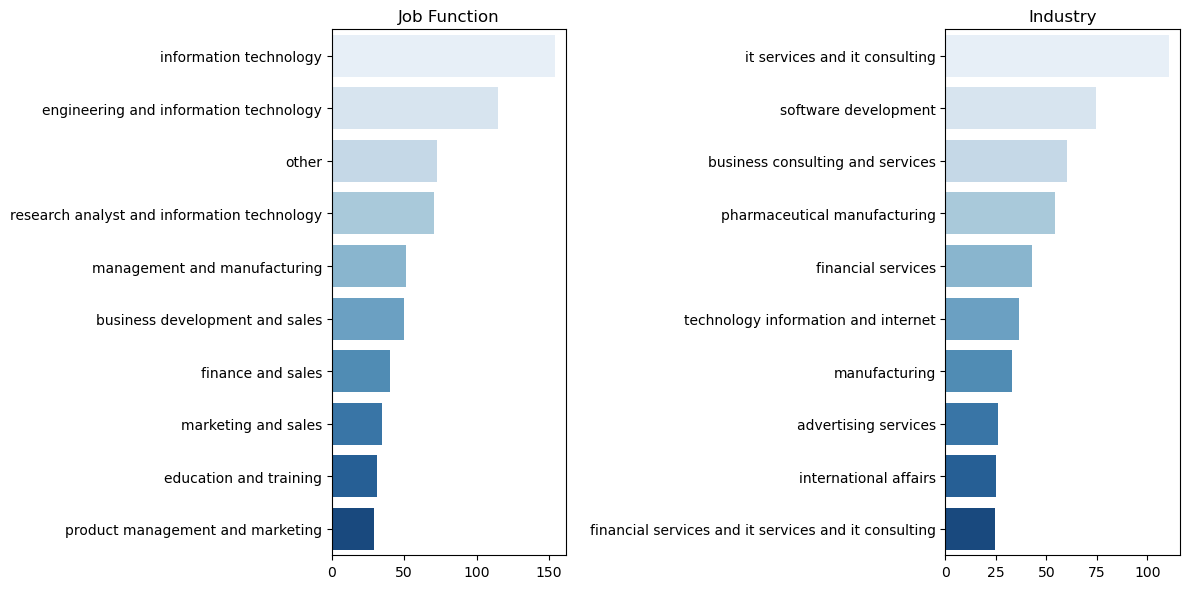

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=data['Job_Function'].value_counts().nlargest(10).values/131*100, 
            y=data['Job_Function'].value_counts().nlargest(10).index,
            hue=data['Job_Function'].value_counts().nlargest(10).index,
            legend=False,
            ax=axes[0],
            orient='h',
            palette = "Blues")
axes[0].set_title("Job Function")
axes[0].yaxis.label.set_visible(False)
    
sns.barplot(x=data['Industry'].value_counts().nlargest(10).values/131*100, 
            y=data['Industry'].value_counts().nlargest(10).index,
            hue=data['Industry'].value_counts().nlargest(10).index,
            legend=False,
            ax=axes[1],
            orient='h',
            palette="Blues")
axes[1].set_title('Industry')
axes[1].yaxis.label.set_visible(False)

plt.tight_layout()
plt.show()

> <div class="alert alert-info">
    <b><i>Barplot with Skills</i></b>
    <a id="Barplot_with_Skills"></a>
#### Extracting the most in demand skills in the industry from descriptions and adding an additional column to represent the most needed skills in the space

In [39]:
skills_list = ["python", "sql", "power bi", "excel", "tableau", "aws", "azure", "machine learning", "deep learning", 'statistics', 'data visualization', 'cloud computing']

def extract_skills(description):
    if pd.isna(description):  
        return None
    description = description.lower() 
    found_skills = [skill for skill in skills_list if skill in description]
    return found_skills if found_skills else None

data["Skills"] = data["Description"].apply(extract_skills)
data = data.iloc[:, [0, 1, 2, 3, 4, 5, 10, 6, 8, 9, 7]]

In [40]:
import itertools
all_skills = []
for row in data['Skills']:
    if row != None:       
        all_skills.append(row)
all_skills = Counter([item for sublist in all_skills for item in sublist])
def clean_skills(skill_list):
    skills = ast.literal_eval(skill_list) if isinstance(skill_list, str) and skill_list.startswith("[") else skill_list
    return ", ".join(skills) if isinstance(skills, list) else skill_list
data['Skills'] = data['Skills'].apply(clean_skills)

Text(0.5, 1.0, 'Skills that appear most often in job descriptions')

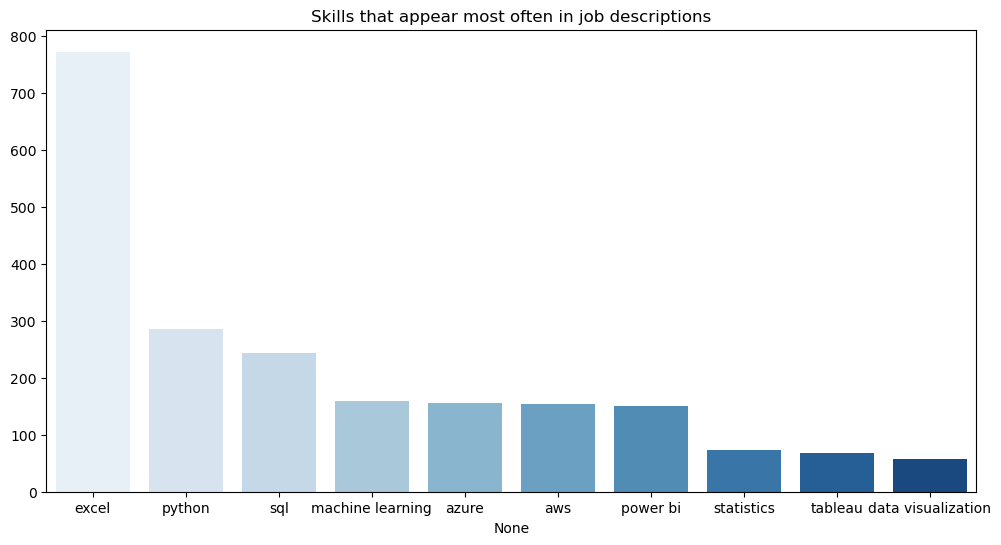

In [66]:
plt.figure(figsize=(12, 6))

top_skills = pd.Series(all_skills).nlargest(10)
sns.barplot(x=top_skills.index,
            y=top_skills.values,
            hue=top_skills.index,
            legend=False,
            palette = "Blues")

plt.title('Skills that appear most often in job descriptions')